In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [31]:
X, y = np.array(mnist.data), np.array(mnist.target)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

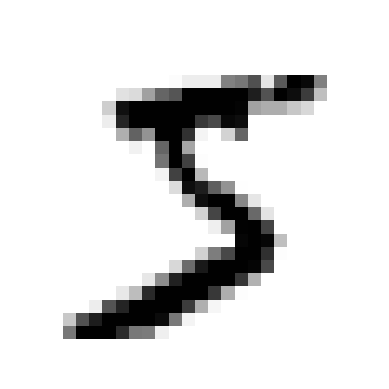

In [15]:
some_digits = X.loc[0].array
some_digits_image = some_digits.reshape(28, 28)

plt.imshow(some_digits_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [12]:
y[0]

'5'

In [13]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
              interpolation = 'nearest')
    plt.axis('off')

In [23]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # append imagenes vacias al final del grid
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis = 0)
    
    # organizar el arreglopara que esté organizado 28x28
    
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    # combinar ejes 0 y 2 y ejes 1 y 3
    
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    
    # mostrar la imagen
    
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

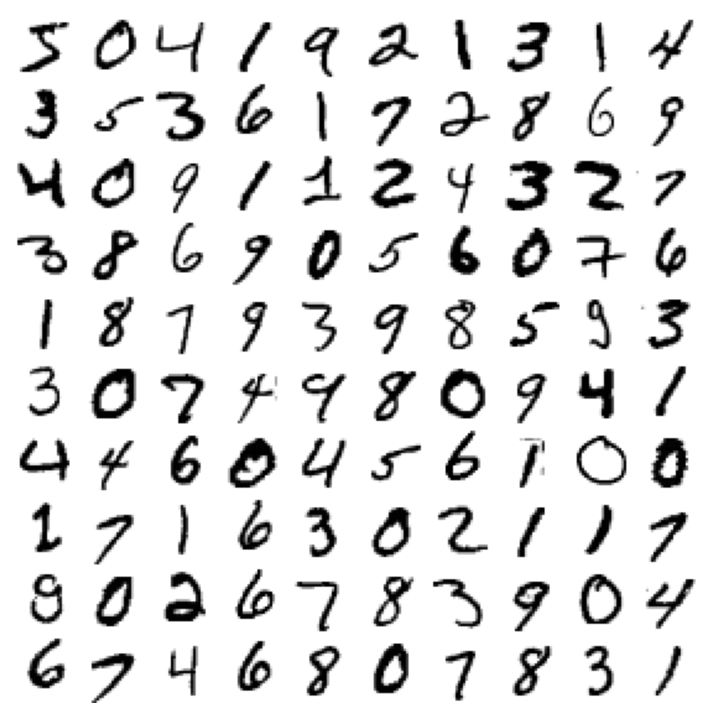

In [25]:
plt.figure(figsize = (9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
plt.show()

Primero crear los datos de entrenamiento y prueba, en este caso estos datos ya están separados

In [32]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Entrenando una clasificador binario

Por ahora queremos identificar el numero 5, creamos un clasificador que distringue dos clases, numero 5 u otro numero

In [40]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Vamos a usar el clasificador *Stochastic Gradient Descent (SGD)*, este clasificador maneja grandes cantidados de datos muy bien ya que se encarga de las instancias de entrenamiento independientemente, una a la vez, por lo cual también es bueno para aprendizaje en linea.

In [41]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [42]:
sgd_clf.predict([some_digits])

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Medidas de rendimiento

Se usa una validación cruzada k fold con 3 folds

In [43]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

Parece un resultado muy bueno, ahora veamos un clasificador que clasifica cada numero en la clase 'no 5'

In [44]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(slef, X):
        return np.zeros((len(X), 1), dtype = bool)

In [45]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Tenemos resultados de más del 90 solo clasificando a todos como no 5, esto es porque solo 10% de llas imagenes son 5, si adivinas que todas las imagenes no son 5 vas a estar en lo correcto 90% de las veces, por esto accuracy no es la medida preferida para clasificaciones, especialmente para datos sesgados, por lo tanto necesitamos otra métrica para medir el rendimiento.

## Matriz de confusión

Para tener la matriz de confusión tenemos que tener predicciones para compararlas a valores actuales

In [46]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Esta función devuelve las predicciones hechas en cada fold, ahora obtenemos la matriz de confusión

In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

La primer columna considera las imagenes no 5, 53892 se clasificaron correctamente (true negatives), mientras que 1821 se clasificaron erroneamente como no 5 (falsos negativos), 3530 se clasificaron correctamente como 5's (true positives), podemos sacar distintas medidas de la matriz de confusión,

$$
precision = \frac{TP}{TP+FP}
$$

La exactitud de las predicciones positivas se llama la precisión, esta métrica se usa con otra llamada recall o sensitividad, el radio de instancias positivas que se detectan correctamente por el clasificador.

$$
recall = \frac{TP}{TP+FN}
$$

## Precisión y sensitividad

In [48]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687)

0.8370879772350012

In [49]:
recall_score(y_train_5, y_train_pred) # 3530 / (3530 + 1891)

0.6511713705958311

Podemos ver que el modelo solo es correcto un 65% de las veces, ya no es tan bueno como parecia antes

A veces es conveniente combinar precision y recall en una sola métrica, a esta la llamamos F1,

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}}
$$

In [50]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

El F1 favorece clasificadores que tienen precisiones y recalls similares, uno no siempre quiere eso, algunas veces se necesita más de uno que del otro dependiendo del contexto, por ejemplo si se entrena un clasificador para detectar videos seguros para niños, probablemente se prefiera un clasificador que rechace muchos buenos videos (recall bajo) pero que se quede con solo buenos (alta precisión), en otro caso, quieres detectar ladrones por imagenes, probablemente está bien si se tiene una precisión del 30% siempre que tenga un recall del 99% ( se recibiran muchas falsas alarmas pero se atraparan a la mayoria de ladrones),  lastimosamente incrememntar precision reduce recall y vice versa, esto se llama el cambio de precision/recall

## Cambio entre precisión y recall

El clasificador SGD computa un puntaje basado en una función de decisión. Si el puntaje es más grande que un threshold, assigna la instancia a la clase positiva, de otro modo lo asigna a la clase negativa, aumentar el threshold reduce el recall y aumenta la precisión (no siempre es bueno), podemos usar la función para obtener los puntajes en vez de las predicciones. 

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                            method = 'decision_function')

In [67]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, 
                                                       y_scores)

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precisión')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                           
    plt.axis([-50000, 50000, 0, 1])            

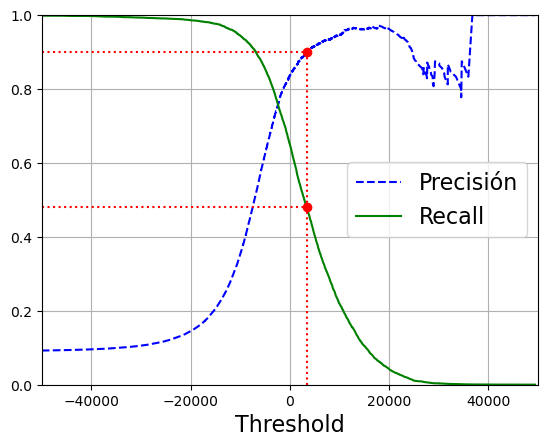

In [72]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  
plt.show()

Otra forma de seleccionar una buen nivel es graficar la precisión vs recall

In [64]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth = 2)
    plt.xlabel('Recall', fontsize = 16)
    plt.ylabel('Precisión', fontsize = 16)
    plt.axis([0,1,0,1])
    plt.grid(True)

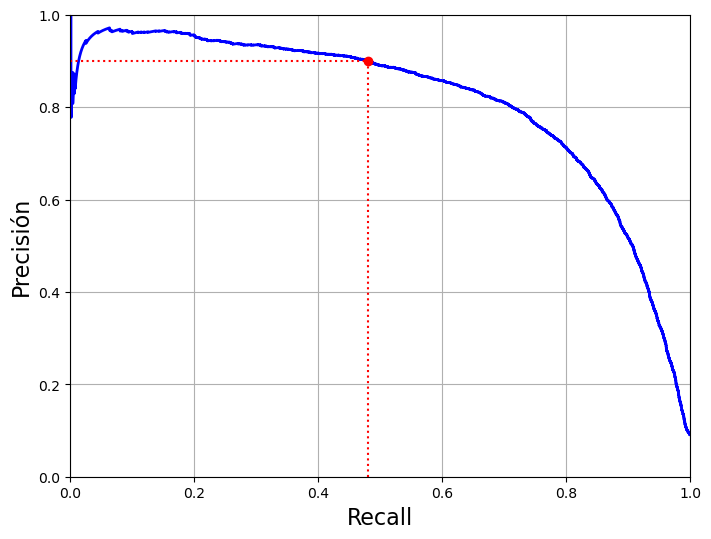

In [71]:
plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

Vemos que la precisión empieza a caer bastante sobre el 80% de recall, sería mejor escoger una combinación antes de esa caida, por ejemplo en recall 60%, supongamos que te decides por una precisión de 90%, mirando en el primer gráfico se necesita un threshold de 8000, podemos buscar el threshold más pequeño que te de minimo 90% precisión

In [73]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

Para hacer predicciones ahora se puede usar este código,

In [74]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [75]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [76]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Obtenemos una precisión del 90% con un recall del 47%

## La curva ROC

La curva *receiving operating characteristic (ROC)* es otra herramienta para clasificadores binarios, la curva grafica el radio de verdaderos positivos (recall) contra el radio de falsos positivos (las instancias negativas clasificadas como positivas) es igual a 1 - el radio de verdaderas negativas (especificidad), la curva ROC grafica sensitividad vs especificidad.

In [77]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [79]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(True)
    plt.xlabel('Radio de falsos positivos')
    plt.ylabel('Radio de verdaderos positivos')

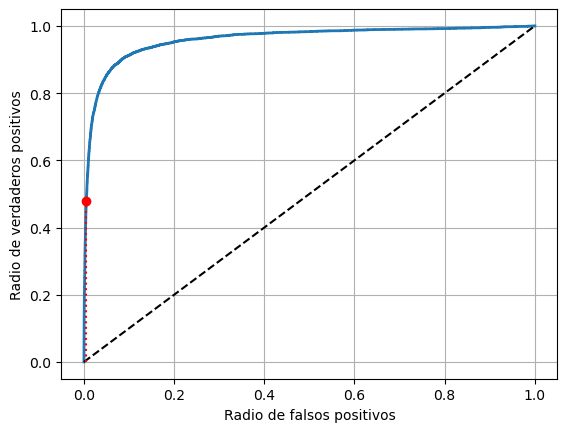

In [81]:
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]  
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

Entre más grande el recall (TPR), va a haber más falsos positivos (FPR), aquí se muestra el recall escogido de 47% para una precisión del 90%, podemos usar la curva roc para comparar clasificadores, una curva perfecta va a tener un ROC AUC igual a 1, un clasificador puro al azar va a tener un ROC AUC iguala 0.5 (Area Under the Curve).

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Tip: Se prefiere la curva PR cuando la clase positiva es rara o cuando importan mas los falsos positivos que los falsos negativos, en otro caso se usa la curva ROC

Ahora entrenemos una RandomForestClassifier y comparemos modelos, el RandomForestClassifier no tiene una función de decisión, en cambio tiene un metodo predict_proba(), devuelve un arreglo que contienen una fila por instancia y una columna por clase, cada una contiene la probabilidad de que dicha instancia pertenezca a dicha clase

In [84]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = 'predict_proba')

In [90]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

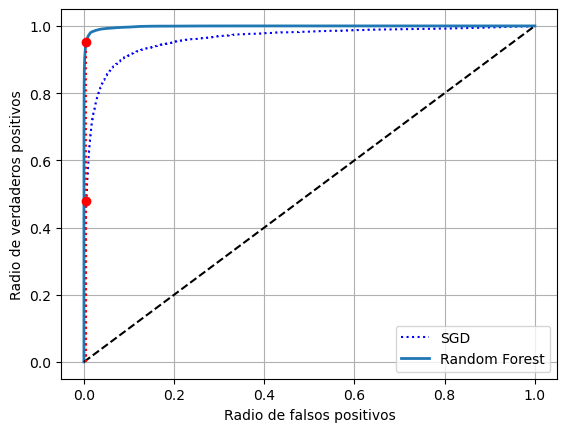

In [91]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'best')
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.show()

In [92]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

El modelo de árboles es mucho mejor

In [96]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [95]:
recall_score(y_train_5, y_train_pred_forest)

0.6511713705958311

## Clasificación multiclase

Algunos algoritmos (SGD, Random Forest, Naive Bayes) pueden soportar multiples clases, otros como (regresión logistica, SVMC) son estrictamente binarios, sin embargo se pueden emplear estrategias para lograr clasificación de multiples clases.

Una de estas es crear un sistema que calsifique los digitos en 10 clases (del 0 al 9), se entrenan 10 clasificadores binarios, uno por cada digito, cuando quieras clasificar una imagen, obtienes el puntaje de cada clasificador y seleccionas el mejor puntaje, esta estrategia es llamada *uno vs el resto (OvR)*

Otra estrategia es entrenar clasificadores binarios para cada apreja de digitos, para el 0 vs 1, 0 vs 2, etc, esta estrategia se llama *uno vs uno (OvO)*, si hay N clases se necesita entrenar $N \times (N-1) / 2$ clasificadores, para una imagen tienes que correr la imagen por 45 clasificadores y ver que clase gana la mayoría de duelos, la ventaja principal es que cada clasificador solo necesita ser entrenado en la parte del conjunto de entrenamiento para las dos clases que debe distinguir.

Algunos algoritmos escalan mal con el tamaño del conjunto de entrenamiento (SVMC), para estos algoritmos OvO es preferido, ya que entrena muchos clasificadores en tamaños pequeños, sin embargo, para la mayoría de clasificadores binarios OvR es preferido.

Scikit learm detecta autmoaticamente cuando usas un clasificador binario para un problema de clasificación multiple y automaticamente corre OvR o OvO dependiendo del algoritmo.

In [100]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digits])

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array(['5'], dtype=object)

Automaticamente scikit-learn usa OvO y entrena 45 clasificadores binarios, encontró los puntajes en cada uno y escogió la clase que ganó la mayoría de duelos.

Si llamamos la función de decisión devuelve 10 puntajes por instancia, 1 puntaje por clase

In [102]:
some_digits_scores = svm_clf.decision_function([some_digits])
some_digits_scores

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

La clase 5 tiene el mayor puntaje!

Ahora, si queremos usar OvO o OvR, podemos usar las clases OneVsOneClassifier or OneVsRestClassifier

In [109]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digits])

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with featu

array(['5'], dtype='<U1')

Para entrenar un modelo SGD o RandomForest, es muy facil ya que pueden clasificar en multiples clases naturalmente

In [106]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digits])

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array(['3'], dtype='<U1')

Este modelo cree que el digito es un 3, pero es un 5.

In [107]:
sgd_clf.decision_function([some_digits])

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [111]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digits])

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['5'], dtype=object)

El modelo de árboles si lo clasifica como un 5!

In [110]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

Obtiene un 85% de accuracy, escalando los inputs podemos aumentarla!

In [113]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3,
               scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

Se aumentó el accuracy solo escalando las variables

## Análisis de error

Si se quiere mejorar el modelo escogido se puede analizar el error que comete, primero miremos la matriz de confusión


In [125]:
from sklearn.metrics import ConfusionMatrixDisplay

In [124]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,
                                cv = 3)

NameError: name 'ConfusionMatrixDisplay' is not defined

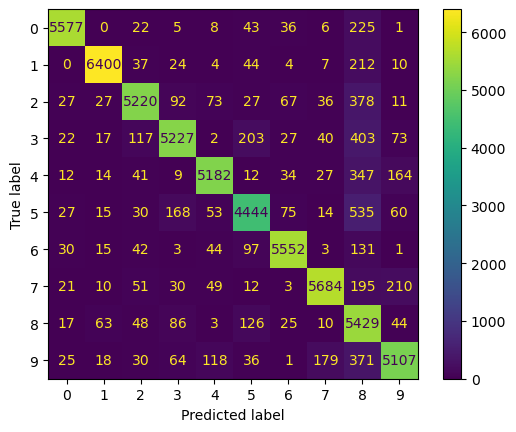

In [126]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

Es mejor verlo en una imagen

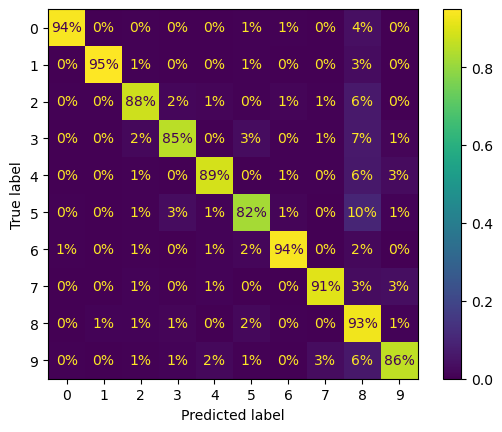

In [127]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
normalize="true", values_format=".0%")
plt.show()

Parece estar bien, la mayoría de datos están en la diagonal, los 5 se venun poco menos oscuros puede ser que haya menos imagenes de 5 o que el clasificador no funciona bien para los 5's. 

Dividamos cada valor por el total de imagenes en la clase correspondiente

In [117]:
row_sums = conf_mx.sum(axis =1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

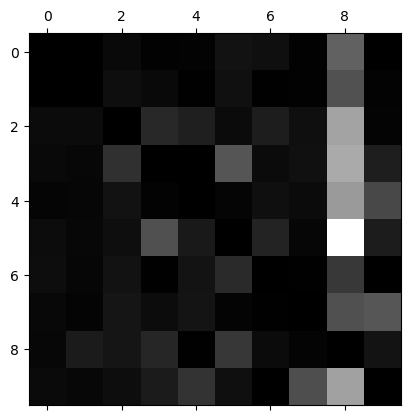

In [118]:
# rellenar de 0 para solo tener los errores

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Muchas imagenes quedan mal clasificadas como 8's los 3's y 5's también se confunden mucho, esto se puede mejorar teniendo mas datos de entrenamiento para 8's, tener más datos que parezcan 8's pero no sean, crear nuevas variables que cuenten el numero de circulos cerrados en el número, o preprocesar las imagenes para encontrar patrones

### Ejercicios

1. Construir un clasificador para MNIST que obtenga 97% de accuracy en el conjunto de prueba


In [19]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

Ahora haciendo ajuste de parámetros

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform', 'distance'], 
              'n_neighbors': [3, 4, 5, 6]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv = 5)
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [11]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [12]:
grid_search.best_score_

0.9441999999999998

Se empeoró pero puede ser porque sólo usamos 10000 observaciones, ahora se hace con todas las observaciones,

In [13]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

Se obtiene más del 97% de accuracy!

2. Escribir una función que pueda mover una imagen MNIST en cualquier dirección por un pixel, luego por cada imagen en el conjunto de entrenamiento crear 4 copias movidas (una por dirección) y añadirlas al conjunto de entrenamiento

In [14]:
from scipy.ndimage import shift

In [15]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval = 0, mode = 'constant')
    return shifted_image.reshape([-1])

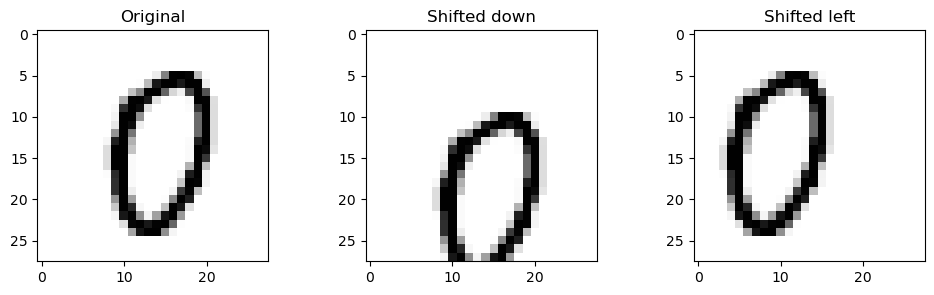

In [34]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [35]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [36]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [37]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [38]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [39]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

3. Hacer el titanic dataset de Kaggle

In [38]:
train = pd.read_csv("C:/Users/Usuario/OneDrive - Universidad Nacional de Colombia/Escritorio/Clases/Kaggle/titanic/train.csv")
test = pd.read_csv("C:/Users/Usuario/OneDrive - Universidad Nacional de Colombia/Escritorio/Clases/Kaggle/titanic/test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Dejemos el passengerID como el index

In [39]:
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Cabin, embarked y age tienen valores perdidos. se imputará la edad con la mediana para hacerlo simple, mejores imputaciones se pueden hacer.

In [7]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Sólo sobrevivieron 38% de los pasajeros, accuracy es una buena métrica para medir el modelo

In [8]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [56]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [57]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Empecemos a crear la pipeline para variables numéricas

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [11]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

Ahora para variables categóricas

In [12]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [13]:
cat_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse = False))
])

Unamos las dos pipelines

In [14]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [20]:
X_train = preprocess_pipeline.fit_transform(train)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [16]:
y_train = train['Survived']

Se empieza por un modelo de RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [47]:
X_test = preprocess_pipeline.fit_transform(test)
y_pred = forest_clf.predict(X_test)

Ya tenemos nuestro modelo pero evaluemoslo para ver que tal se desempeña

In [22]:
from sklearn.model_selection import cross_val_score 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10)
forest_scores.mean()

0.8092759051186016

Es una buen resultado pero intentemos otro modelo.

In [23]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = 'auto')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

0.8249313358302123

Veamos graficamente los resultados

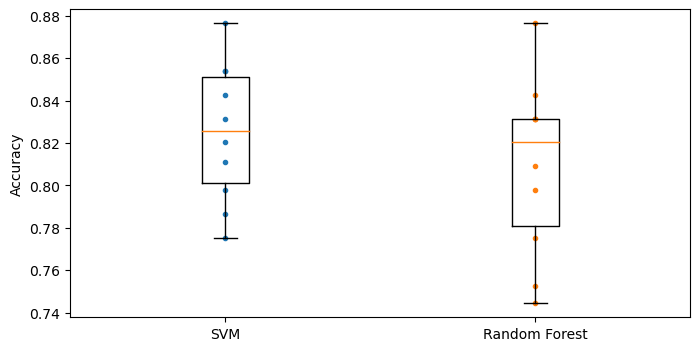

In [79]:
plt.figure(figsize = (8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels = ('SVM', 'Random Forest'))
plt.ylabel('Accuracy')
plt.show()

El SVM rinde mejor para este problema, cosas que se puede hacer para mejorar nuestro modelo:

1. Comparar mas modelos y ajustar hiperparámetros
1. Hacer feature engineering

In [24]:
train['AgeBucket'] = train['Age'] // 15 * 15
train[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train['RelativeOB'] = train['SibSp'] + train['Parch']
train[['RelativeOB', 'Survived']].groupby(['RelativeOB']).mean()

In [31]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'kernel': ['linear', 'poly', 'rbf'], 
              'gamma': [0.1, 1, 10],
              'C': [0.1, 1, 10, 100],
              'degree': [0, 1, 2, 3]}]


rand_search = RandomizedSearchCV(svm_clf, param_grid, cv = 5, scoring = 'accuracy')
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(gamma='auto'),
                   param_distributions=[{'C': [0.1, 1, 10, 100],
                                         'degree': [0, 1, 2, 3],
                                         'gamma': [0.1, 1, 10],
                                         'kernel': ['linear', 'poly', 'rbf']}],
                   scoring='accuracy')

In [34]:
rand_search.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'degree': 3, 'C': 1}

In [44]:
rand_search.best_estimator_.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

In [45]:
rand_search.score(X_train, y_train)

0.835016835016835

Aumentamos en 3% el accuracy

In [49]:
y_pred = rand_search.best_estimator_.predict(X_test)

In [57]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [60]:
titanic = pd.DataFrame({'PassengerId': test.index, 'Survived': y_pred})

In [61]:
titanic.to_csv("C:/Users/Usuario/OneDrive - Universidad Nacional de Colombia/Escritorio/Clases/Kaggle/submissions/titanic.csv", index=False)

4. Crear un clasificador que detecte correos spam

In [12]:
from six.moves import urllib
from pathlib import Path

In [13]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [14]:
ham_dir, spam_dir = fetch_spam_data()

Cargar los emails

In [15]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [16]:
len(ham_filenames)

2500

In [17]:
len(spam_filenames)

500

In [20]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [21]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Veamos un ejemplo,

In [22]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [23]:
print(ham_emails[6].get_content().strip())

The Scotsman - 22 August 2002

 Playboy wants to go out with a bang 
 
 
 AN AGEING Berlin playboy has come up with an unusual offer to lure women into
 his bed - by promising the last woman he sleeps with an inheritance of 250,000
 (£160,000). 
 
 Rolf Eden, 72, a Berlin disco owner famous for his countless sex partners,
 said he could imagine no better way to die than in the arms of an attractive
 young woman - preferably under 30. 
 
 "I put it all in my last will and testament - the last woman who sleeps with
 me gets all the money," Mr Eden told Bild newspaper. 
 
 "I want to pass away in the most beautiful moment of my life. First a lot of
 fun with a beautiful woman, then wild sex, a final orgasm - and it will all
 end with a heart attack and then Im gone." 
 
 Mr Eden, who is selling his nightclub this year, said applications should be
 sent in quickly because of his age. "It could end very soon," he said.


------------------------ Yahoo! Groups Sponsor ---------------------~

Algunos emails tienen varias partes con diferentes imagenes y attachments, veamos las estructuras que podemos tener

In [28]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [29]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [30]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [31]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

los emails ham son más frecuentemente texto plano mientras los correos spam tiene mucho HTML, veamos los encabezados

In [32]:
for header, value in spam_emails[0].items():
    print(header, ':', value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Aquí el correo del que envía parece spam (12a1mailbot1@web.de), veamos el asunto del correo

In [33]:
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

Ahora dividamos el conjunto en entrenamiento y prueba

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype = object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   random_state = 42)

Ahora vamos a escribir las funciones del pre procesamiento, primero necesitamos una función para convertir HTML a texto plano, lo mejor para hacer esto es beautifulSoup, pero aquí se hace una función propia

In [46]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Ahora como funciona,

In [47]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [48]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [49]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [50]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [51]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [52]:
%pip install -q -U urlextract

Note: you may need to restart the kernel to use updated packages.


In [53]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Ahora hacemos un transformador que convierte emails a un contador de palabras,

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [55]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [ ]:
Ahora necesitamos transformar esto a vectores

In [56]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [57]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [58]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

Esto significa que el segundo email contiene 99 palabras que no son parte del vocabulario, el 11 significa que la primer palabra en el diccionario está presente 11 veces, la segunda palabra se repite 9 veces, veamos las palabras del vocabulario,

In [59]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

Ahora creemos el clasificador de spam,

In [61]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

In [63]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%
